In [153]:

import os
import pickle
import pprint

import pandas as pd

mapper_tests = {}


def get_objs_by_folder():
    directory = 'results'
    objs = []
    for root, subdirs, files in os.walk(directory):
        if root != 'results':
            tests_list = []
            for file in files:
                if file != '.DS_Store':
                    tests_list.append(file)
                    f = os.path.join(directory, str(root).split('/')[1] + '/' + file)
                    if os.path.isfile(f) and file.endswith('data'):
                        with open(f, 'rb') as filehandle:
                            # read the data as binary data stream
                            while 1:
                                try:
                                    objs.append(pickle.load(filehandle))
                                except EOFError:
                                    break
            mapper_tests[str(root).split('/')[1]] = tests_list
    return objs


# get_objs_by_folder()


def get_objs():
    directory = 'results'
    objs = []
    for k in mapper_tests.keys():
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename + '/' + k)
            if os.path.isfile(f) and filename.endswith('data'):
                with open(f, 'rb') as filehandle:
                    # read the data as binary data stream
                    while 1:
                        try:
                            objs.append(pickle.load(filehandle))
                        except EOFError:
                            break
        return objs

In [154]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from face_recognition.api import get_known_people_from_dataset


In [155]:
#TODO: get detection percentage out of every person

safe_mapper = {}
total_known_acc = 0


def generate_matrix_data(objs):
    unique_people = []
    people_list = []
    objs.sort(key=lambda x: x[0])
    for idx, results in enumerate(objs):
        if not results[0].startswith('stock'):
            people_list.append(results[0])

    unwanted_list = remove_unwanted_cols(people_list)
    lst = list(filter(lambda x: not x[0].startswith('stock'), objs))
    person_data = list(filter(lambda x: x[0] not in unwanted_list, lst))
    for data in person_data:
        unique_people.append(data[0])
    unique_people.append('unknown')
    size = len(lst)
    objs = lst
    matrix_data = np.zeros((size, len(unique_people)), dtype=np.float64)
    mapper = {'unknown': size}
    for idx, results in enumerate(objs):
        actual_name = results[0]
        mapper[actual_name] = idx

    for idx, results in enumerate(objs):
        actual_name = results[0]
        output_faces = results[1]
        global total_known_acc
        total_known_acc += results[2]
        if len(results) >= 4:
            safe_mapper[actual_name] = results[3]
        # print(actual_name, output_faces)

        for name, count in output_faces.items():
            if name in mapper.keys():
                X = 100 * count / sum(output_faces.values())
                # print(actual_name, name)
                # print(int(mapper[actual_name]), int(mapper[name]))
                index = unique_people.index(name)
                matrix_data[int(mapper[actual_name])][index] = X

    total_known_acc = total_known_acc / len(objs)
    return matrix_data, people_list, unique_people

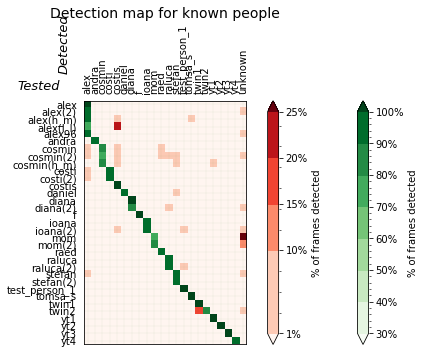

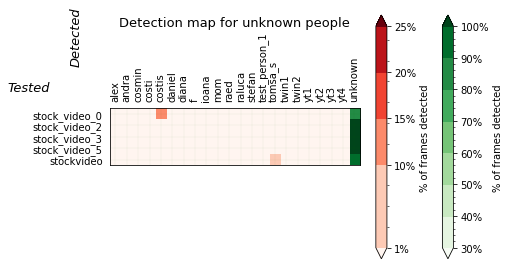

30-frame safe: (= no existing set of 30 consecutive frames detecting the wrong person)
{'alex': True,
 'alex(2)': True,
 'alex(h_m)': True,
 'alex(l_l)': True,
 'andra': True,
 'cosmin': True,
 'cosmin(h_m)': True,
 'costi': True,
 'costi(2)': True,
 'daniel': True,
 'diana': True,
 'diana(2)': True,
 'ioana': True,
 'ioana(2)': True,
 'mom': True,
 'mom(2)': True,
 'raed': True,
 'raluca': True,
 'raluca(2)': True,
 'stefan': True,
 'stefan(2)': True,
 'yt1': True,
 'yt2': True,
 'yt4': True}
None
{'stock_video_0': True,
 'stock_video_2': True,
 'stock_video_3': True,
 'stock_video_5': True,
 'stockvideo': True}
None
General accuracy over known people 93.59240370899794
General accuracy over unknown people 80.29052738656893


In [156]:
stock_safe_mapper = {}
total_unknown_acc = 0


def generate_stock_matrix_data(objs, unique_people):
    stock_people_list = []
    objs.sort(key=lambda x: x[0])
    for idx, results in enumerate(objs):
        if results[0].startswith('stock'):
            if results[0] not in stock_people_list:
                stock_people_list.append(results[0])

    lst = list(filter(lambda x: x[0].startswith('stock'), objs))
    # print(lst)
    size = len(lst) - 1
    objs = lst
    stock_matrix_data = np.zeros((size, len(unique_people)), dtype=np.float64)
    mapper = {'unknown': size}
    for idx, results in enumerate(objs):
        actual_name = results[0]
        mapper[actual_name] = idx
    # print(objs)
    # print('mapper', mapper)
    for idx, results in enumerate(objs):
        actual_name = results[0]
        output_faces = results[1]
        global total_unknown_acc
        total_unknown_acc += results[2]
        if len(results) >= 4:
            stock_safe_mapper[actual_name] = results[3]
        # print(actual_name, output_faces)
        # print(output_faces)
        if type(output_faces) != str:
            for name, count in output_faces.items():
                X = 100 * count / sum(output_faces.values())
                # print(actual_name, name)
                # print(int(mapper[actual_name]), int(mapper[name]))
                index = unique_people.index(name)
                stock_matrix_data[int(mapper[actual_name]) - 1][index] = X
    total_unknown_acc = total_unknown_acc / len(objs)
    return stock_matrix_data, stock_people_list


def remove_unwanted_cols(people_list):
    unwanted_list = []
    dataset_people = get_known_people_from_dataset()
    for f in mapper_tests.values():
        for t in f:
            split = t.split('.data')[0]
            if split in people_list and split not in dataset_people:
                unwanted_list.append(split)
    return unwanted_list


pass

from numpy.ma import masked_array


def plot_matrix(arr, people_list):
    fig, ax = plt.subplots()
    ax.matshow(arr, cmap='Greens', interpolation='none')

    ax.set_xticks(list(range(len(unique_people))))
    ax.set_xticklabels(unique_people)

    ax.set_yticks(list(range(len(people_list))))
    ax.set_yticklabels(people_list)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    plt.title("Detection map for known people", fontsize=14)
    fig.set_facecolor("white")

    bounds = [30, 40, 50, 60, 70, 80, 90, 100]
    bounds_reds = [1, 10, 15, 20, 25]

    cmap = mpl.cm.Greens
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

    cmap_reds = mpl.cm.Reds
    norm_reds = mpl.colors.BoundaryNorm(bounds_reds, cmap_reds.N, extend='both')

    greens = masked_array(arr, arr < 30)
    reds = masked_array(arr, arr >= 30)

    plt.xticks(rotation=90)

    pos_neg_clipped = ax.imshow(greens,
                                cmap="Greens",
                                interpolation='none',
                                norm=norm)

    pos_neg_clipped_reds = ax.imshow(reds,
                                     cmap="Reds",
                                     interpolation='none',
                                     norm=norm_reds)

    cbar = fig.colorbar(pos_neg_clipped,
                        format='%.0f%' + '%',
                        spacing='proportional',
                        extend='both',
                        label='% of frames detected')

    cbar_reds = fig.colorbar(pos_neg_clipped_reds,
                             format='%.0f%' + '%',
                             spacing='proportional',
                             extend='both',
                             label='% of frames detected')

    ax.text(-9.5, -2, r'Tested', style='italic', fontsize=13, weight='light')
    ax.text(-4, -4.5, r'Detected', style='italic', fontsize=13, rotation='vertical', weight='light')
    cbar.minorticks_on()
    cbar_reds.minorticks_on()

    plt.grid(color='g', linestyle='-.', linewidth=0.05)
    N = 55
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2  # inch margin
    s = maxsize / plt.gcf().dpi * N + 2 * m
    margin = m / plt.gcf().get_size_inches()[0]

    fig.subplots_adjust(bottom=margin, right=1. - margin)
    fig.set_size_inches(s, plt.gcf().get_size_inches()[1])
    plt.savefig('Graph' + ".png")

    plt.show()


def plot_stock_matrix(arr, people_list):
    fig, ax = plt.subplots()
    ax.matshow(arr, cmap='Greens', interpolation='none')

    ax.set_xticks(list(range(len(unique_people))))
    ax.set_xticklabels(unique_people)

    ax.set_yticks(list(range(len(people_list))))
    ax.set_yticklabels(people_list)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    plt.title("Detection map for unknown people", fontsize=13)
    fig.set_facecolor("white")

    bounds = [30, 40, 50, 60, 70, 80, 90, 100]
    bounds_reds = [1, 10, 15, 20, 25]

    cmap = mpl.cm.Greens
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

    cmap_reds = mpl.cm.Reds
    norm_reds = mpl.colors.BoundaryNorm(bounds_reds, cmap_reds.N, extend='both')

    greens = masked_array(arr, arr < 30)
    reds = masked_array(arr, arr >= 30)

    plt.xticks(rotation=90)

    pos_neg_clipped = ax.imshow(greens,
                                cmap="Greens",
                                interpolation='none',
                                norm=norm)

    pos_neg_clipped_reds = ax.imshow(reds,
                                     cmap="Reds",
                                     interpolation='none',
                                     norm=norm_reds)

    cbar = fig.colorbar(pos_neg_clipped,
                        format='%.0f%' + '%',
                        spacing='proportional',
                        extend='both',
                        label='% of frames detected')

    cbar_reds = fig.colorbar(pos_neg_clipped_reds,
                             format='%.0f%' + '%',
                             spacing='proportional',
                             extend='both',
                             label='% of frames detected')

    ax.text(-9.5, -2, r'Tested', style='italic', fontsize=13, weight='light')
    ax.text(-4, -4.5, r'Detected', style='italic', fontsize=13, rotation='vertical', weight='light')
    cbar.minorticks_on()
    cbar_reds.minorticks_on()

    plt.grid(color='g', linestyle='-.', linewidth=0.05)
    N = 40
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2  # inch margin
    s = maxsize / plt.gcf().dpi * N + 2 * m
    margin = m / plt.gcf().get_size_inches()[0]

    fig.subplots_adjust(bottom=margin, right=1. - margin)
    fig.set_size_inches(s, plt.gcf().get_size_inches()[1])
    plt.savefig('Graph_unknown' + ".png")

    plt.show()


objs = get_objs_by_folder()
matrix_data, people_list, unique_people = generate_matrix_data(objs)

stock_matrix, unique_stock = generate_stock_matrix_data(objs, unique_people)
plot_matrix(matrix_data, people_list)
plot_stock_matrix(stock_matrix, unique_stock)

np.set_printoptions(precision=1)

print("30-frame safe: (= no existing set of 30 consecutive frames detecting the wrong person)")
print(pprint.pprint(safe_mapper))
print(pprint.pprint(stock_safe_mapper))
print('General accuracy over known people', total_known_acc)
print('General accuracy over unknown people',total_unknown_acc)


df = pd.DataFrame(data=np.round(matrix_data, 1), index=people_list, columns=unique_people)
df.to_csv(f"Known people.csv", index=True, header=True)

df = pd.DataFrame(data=np.round(stock_matrix, 1), index=unique_stock, columns=unique_people)
df.to_csv(f"Unknown people.csv", index=True, header=True)
